In [1]:
import random
from itertools import product

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline, UnivariateSpline, CubicSpline
from sklearn.preprocessing import MinMaxScaler
from joblib import load
from tqdm import tqdm

In [2]:
results_T3 = load("./RS003_CA_WS_200_12_T3_piece_dip_results.joblib")
results_T2 = load("./RS002_CA_WS_200_8_T2_piece_dip_results.joblib")

In [3]:
df_T3 = pd.DataFrame(results_T3, columns=['p', 'Symmetry', 'Spreading Density', 'Number of Steps','Resilience', 'Delta average', 'cpc_std'])
df_T2 = pd.DataFrame(results_T2, columns=['p', 'Symmetry', 'Spreading Density', 'Number of Steps','Resilience', 'Delta average', 'cpc_std'])

In [4]:
#average grouped by p value
df_T3 = df_T3.groupby('p').mean().reset_index()
df_T2 = df_T2.groupby('p').mean().reset_index()

In [5]:
df_T3 = df_T3.sort_values(by='p')
df_T2 = df_T2.sort_values(by='p')

In [6]:
df_3_original = df_T3.copy()
df_2_original = df_T2.copy()

df_T3 = df_T3[df_T3['p'] < 0.7]
df_T2 = df_T2[df_T2['p'] < 0.7]

In [7]:
df_T3.head()

,p,Symmetry,Spreading Density,Number of Steps,Resilience,Delta average,cpc_std
0,0.000000e+00,0.990770,0.182175,4.842263,0.0,0.026410,0.247095
1,1.818989e-12,0.989354,0.181208,4.817825,0.0,0.028496,0.246964
2,3.637979e-12,0.986983,0.181078,4.815467,0.0,0.031538,0.245230
3,7.275958e-12,0.990643,0.181802,4.832788,0.0,0.026694,0.248269
4,1.455192e-11,0.991452,0.182272,4.845288,0.0,0.025494,0.247994


In [8]:
#do a two sided rolling average for the symmetry and spreading density
df_T3['Symmetry'] = df_T3['Symmetry'].rolling(window=10).mean()
df_T3['Spreading Density'] = df_T3['Spreading Density'].rolling(window=10).mean()
df_T2['Symmetry'] = df_T2['Symmetry'].rolling(window=10).mean()
df_T2['Spreading Density'] = df_T2['Spreading Density'].rolling(window=10).mean()

In [9]:
#drop all NaN values
df_T3 = df_T3.dropna()
df_T2 = df_T2.dropna()

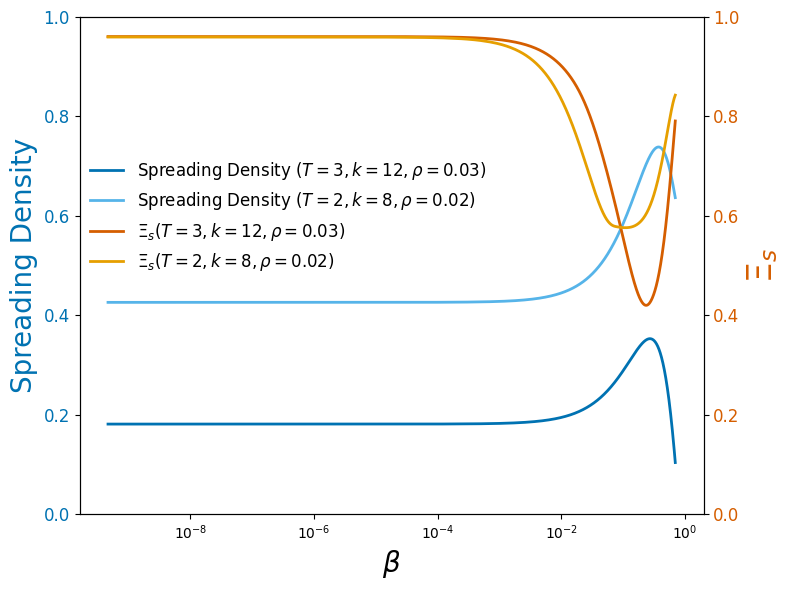

In [10]:
# Figure 22

# Extract data from DataFrames
p_T3, symmetry_T3, spreading_density_T3 = df_T3['p'], df_T3['Symmetry'], df_T3['Spreading Density']
p_T2, symmetry_T2, spreading_density_T2 = df_T2['p'], df_T2['Symmetry'], df_T2['Spreading Density']

# Fit splines for smoothing
spline_T3_symmetry = UnivariateSpline(p_T3, symmetry_T3, s=0.2)
spline_T3_density = UnivariateSpline(p_T3, spreading_density_T3, s=0.2)
spline_T2_symmetry = UnivariateSpline(p_T2, symmetry_T2, s=0.2)
spline_T2_density = UnivariateSpline(p_T2, spreading_density_T2, s=0.2)

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot on primary y-axis
ax1.plot(p_T3, spline_T3_density(p_T3), label="Spreading Density ($T=3, k=12, \\rho=0.03$)", color="#0072B2", lw=2)
ax1.plot(p_T2, spline_T2_density(p_T2), label="Spreading Density ($T=2, k=8, \\rho=0.02$)", color="#56B4E9", lw=2)
ax1.set_xlabel('$\\beta$', fontsize=20)
ax1.set_ylabel('Spreading Density', color="#0072B2", fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor="#0072B2", labelsize=12)

# Plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(p_T3, spline_T3_symmetry(p_T3), label="$\\Xi_s(T=3, k=12, \\rho=0.03$)", color="#D55E00", lw=2)
ax2.plot(p_T2, spline_T2_symmetry(p_T2), label="$\\Xi_s(T=2, k=8, \\rho=0.02$)", color="#E69F00", lw=2)
ax2.set_ylabel('$\\Xi_s$', color="#D55E00", fontsize=24)
ax2.tick_params(axis='y', labelcolor="#D55E00", labelsize=12)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.1, 0.75), fontsize=12, frameon=False)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('dip_plots.png', dpi=300)


In [11]:
#calculate the x value where the minimum of spline_T3_symmetry is
min_x_T3 = p_T3[np.argmin(spline_T3_symmetry(p_T3))]
min_x_T2 = p_T2[np.argmin(spline_T2_symmetry(p_T2))]

print(min_x_T3)
print(min_x_T2)

0.227
0.1


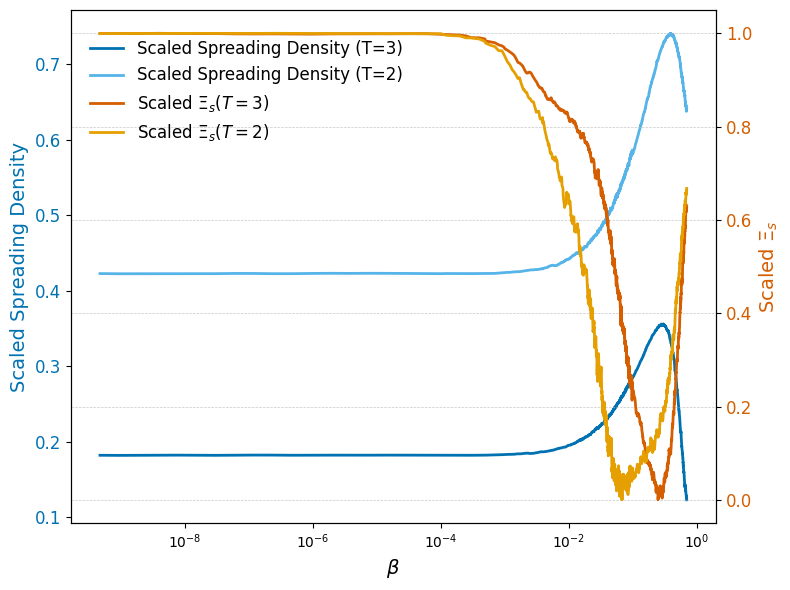

In [12]:
# Extract data from DataFrames
p_T3, symmetry_T3, spreading_density_T3 = df_T3['p'], df_T3['Symmetry'], df_T3['Spreading Density']
p_T2, symmetry_T2, spreading_density_T2 = df_T2['p'], df_T2['Symmetry'], df_T2['Spreading Density']

# Fit splines for smoothing
spline_T3_symmetry = CubicSpline(p_T3, symmetry_T3, bc_type='clamped')
spline_T3_density = CubicSpline(p_T3, spreading_density_T3, bc_type='clamped')
spline_T2_symmetry = CubicSpline(p_T2, symmetry_T2, bc_type='clamped')
spline_T2_density = CubicSpline(p_T2, spreading_density_T2, bc_type='clamped')

# Generate smoothed values
smoothed_T3_density = spline_T3_density(p_T3)
smoothed_T2_density = spline_T2_density(p_T2)
smoothed_T3_symmetry = spline_T3_symmetry(p_T3)
smoothed_T2_symmetry = spline_T2_symmetry(p_T2)

# Min-max scaling function
def min_max_scale(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

# Apply min-max scaling
scaled_T3_density = smoothed_T3_density#min_max_scale(smoothed_T3_density)
scaled_T2_density = smoothed_T2_density#min_max_scale(smoothed_T2_density)
scaled_T3_symmetry = min_max_scale(smoothed_T3_symmetry)
scaled_T2_symmetry = min_max_scale(smoothed_T2_symmetry)

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot on primary y-axis
ax1.plot(p_T3, scaled_T3_density, label="Scaled Spreading Density (T=3)", color="#0072B2", lw=2)
ax1.plot(p_T2, scaled_T2_density, label="Scaled Spreading Density (T=2)", color="#56B4E9", lw=2)
ax1.set_xlabel('$\\beta$', fontsize=14)
ax1.set_ylabel('Scaled Spreading Density', color="#0072B2", fontsize=14)
ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor="#0072B2", labelsize=12)

# Plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(p_T3, scaled_T3_symmetry, label="Scaled $\\Xi_s(T=3)$", color="#D55E00", lw=2)
ax2.plot(p_T2, scaled_T2_symmetry, label="Scaled $\\Xi_s(T=2)$", color="#E69F00", lw=2)
ax2.set_ylabel('Scaled $\\Xi_s$', color="#D55E00", fontsize=14)
ax2.tick_params(axis='y', labelcolor="#D55E00", labelsize=12)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.1, 0.95), fontsize=12, frameon=False)

# Finalize aesthetics
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig('dip_plots_scaled.png', dpi=300)

